# Modeling interference patterns in EIGSEP spectra resulting from multipath reflections in the canyon
## Aaron Parsons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy
import eigsep_terrain as et
import eigsep_terrain.utils as etu
from astropy.time import Time
from dateutil.parser import parse
import tqdm
import sim, hpm
from scipy.constants import c as C
from matvis import coordinates
import hera_filters
import os

real_dtype = np.float32
%matplotlib widget

/home/aparsons/.local/share/mamba/envs/arp/lib/python3.11/site-packages/pyuvdata/analytic_beam.py:174: UserWarning: basis_vector_type was not defined, defaulting to azimuth and zenith_angle.
  warnings.warn(
/home/aparsons/.local/share/mamba/envs/arp/lib/python3.11/site-packages/matvis/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
#RESISTIVITY_OHM_M = 2e12 # Ohm m, calcite, Telford et al. 1976
#RESISTIVITY_OHM_M = 50 # Ohm m, lower bound limestone, Telford et al. 1976
RESISTIVITY_OHM_M = 3e2 # Ohm m, middle of the road?
#RESISTIVITY_OHM_M = 1e3 # Ohm m, typical shale, Telford et al. 1976
#RESISTIVITY_OHM_M = 1e7 # Ohm m, upper bound limestone, Telford et al. 1976

def reflectivity(freqs, resistivity_ohm_m=RESISTIVITY_OHM_M, eta0=1):
    omega = 2 * np.pi * freqs # Hz
    conductivity = etu.conductivity_from_resistivity(resistivity_ohm_m)
    eta = etu.permittivity_from_conductivity(conductivity, freqs)
    R = etu.reflection_coefficient(eta, eta0=eta0)
    return R

In [3]:
BEAM_NPZ = 'eigsep_bowtie_v000.npz'
HORIZON_NPZ = 'horizon_models_v000.npz'
heights = np.load(HORIZON_NPZ)['heights']
NCHAN = 256

freqs = np.linspace(50e6, 250e6, NCHAN).astype(real_dtype)
beam = sim.Beam(freqs, filename=BEAM_NPZ)
#T_21cm = sim.load_T21cm_models(freqs, model_index=120)
#bandpass = sim.load_bandpass(freqs)
terrain = sim.Terrain(freqs, height=heights[-1])
gamma = reflectivity(freqs).astype(real_dtype)

t_start = Time(parse('2024-10-17T12:00:00-6:00'))  # local time at Marjum Pass
t_end   = Time(parse('2024-10-18T12:00:00-6:00'))  # local time at Marjum Pass
NTIMES = 24 * 6
times = Time(np.linspace(t_start.jd, t_end.jd, NTIMES), format='jd')

gsim = sim.GlobalSim(times, freqs, beam, terrain)

In [4]:
NSIDE_SCAT = 8
TGND = 300.0  # K
TIND = 0

npix_scat = healpy.nside2npix(NSIDE_SCAT)
Tsky_scat = np.empty((npix_scat, freqs.size), dtype=real_dtype)
for i in range(freqs.size):
    # average over pixels to get a temperature map with degraded resolution
    Tsky_scat[:, i] = healpy.ud_grade(gsim.sky_model[:, i], NSIDE_SCAT, power=0, dtype=real_dtype)
th, ra = healpy.pix2ang(NSIDE_SCAT, np.arange(npix_scat))
dec = np.pi/2 - th
crd_eq_scat = np.asarray(coordinates.point_source_crd_eq(ra, dec), dtype=real_dtype)
eq2top_m = gsim.get_rotation_matrix(TIND)  # doing one integration only for now
_tx, _ty, _tz = rhat_scat = eq2top_m.dot(crd_eq_scat)
tx, ty, tz = rhat = np.array(gsim.get_topocentric(TIND), dtype=real_dtype)
bm_scat = gsim.beam_response(rhat_scat)
bm = gsim.beam_response(rhat)
df = freqs[2] - freqs[1]

In [5]:
heights = np.array([10, 20, 30, 40, 60, 80, 100])

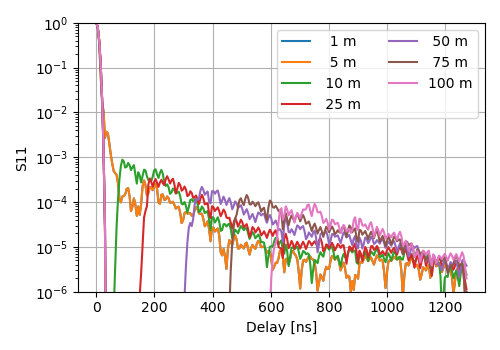

In [9]:
# Generate S11-type terrain reflection plot
_NCHAN = 2 * NCHAN
_freqs = np.linspace(freqs[0], freqs[-1], _NCHAN)
S11 = sim.load_S11(_freqs)
_df = _freqs[1] - _freqs[0]
tau_bins = np.linspace(0, 0.5/_df, _NCHAN//2+1, endpoint=False)
bin_edges = np.empty(_NCHAN//2+2, dtype=tau_bins.dtype)
dbin = tau_bins[1] - tau_bins[0]
bin_edges[:-1] = tau_bins - dbin/2
bin_edges[-1] = tau_bins[-1] + dbin/2
window = hera_filters.dspec.gen_window('bh7', _freqs.size)
_gamma = reflectivity(_freqs).astype(real_dtype)

plt.figure(figsize=(5, 3.5))
for hind, height in enumerate([1, 5, 10, 25, 50, 75, 100]):
    terrain = sim.Terrain(freqs, height=height)
    rmag = terrain[tx, ty, tz]
    is_gnd = ~np.isnan(rmag)
    weights = 1 / rmag[is_gnd]  # incoherent scattering, for voltage
    hist, _ = np.histogram(2 * rmag[is_gnd] / C, weights=weights, bins=bin_edges)
    spec = 1 + np.fft.irfft(hist) * _gamma * (1 - S11)**2  # square 1-S11 to account for out and back
    dspec = np.fft.rfft(spec * window)
    dspec /= dspec[0]
    plt.semilogy(tau_bins * 1e9, np.abs(dspec), label=f'{height:3.0f} m')
plt.ylim(1e-6, 1e0)
plt.ylabel('S11')
plt.grid()
plt.legend(ncol=2, loc='best')
plt.xlabel('Delay [ns]')
plt.tight_layout()

In [10]:
FILENAME = 'tscat.npz'

if not os.path.exists(FILENAME):
    T_scat = np.zeros((heights.size, healpy.nside2npix(gsim.nside), freqs.size), dtype=real_dtype)
    
    for hind, height in enumerate(heights):
        terrain = sim.Terrain(freqs, height=height)
        rmag_scat = terrain[_tx, _ty, _tz]
        is_gnd_scat = ~np.isnan(rmag_scat)
        rvec_scat = rhat_scat * rmag_scat[None, :] # only terrain pixels
        Tsky_scat[is_gnd_scat] = TGND
        rmag = terrain[tx, ty, tz]
        is_gnd = ~np.isnan(rmag)
        rvec = rhat * rmag[None, :] # only terrain pixels
        
        # every visible pixel on the sky takes a direct path to the antenna, and it also takes an indirect path to each terrain point
        # visible to the antenna, where it can bounce and enter the antenna. The path length difference is the radial distance
        # from the antenna to the terrain point, plus the baseline distance from the antenna to the terrain point projected toward
        # each sky point.
        # This baseline is np.dot(r * crd[terrain], crd[sky])
        bl_proj = np.dot(rhat_scat.T, rvec)  # differential distance between ant and gnd, projected toward source
        bm_mask_scat = np.where(np.dot(rhat_scat.T, rhat) > 0, 0, 1)  # mask out reflections below the normal surface
        # XXX but might want to think about a beam relative to the reflection around the  normal to the surface
        d_traveled = bl_proj + rmag[None, :]  # extra distance from gnd to ant
        
        # need separate interference calculation for gnd-gnd scattering, since
        # gnd elements are near-field, so d_traveled = |r[i] - r[j]| + |r[j]| - |r[i]|
        d_traveled[is_gnd_scat, :] = np.linalg.norm(rvec_scat[:, is_gnd_scat, None] - rvec[:, None, :], axis=0) + \
                                     rmag[None, :] - rmag_scat[is_gnd_scat, None]
        
        # average T over all sky reflections; could put a scattering beam in here
        for ch in tqdm.tqdm(range(freqs.size)):
            T_scat[hind, is_gnd, ch] = np.mean(
                gamma[ch] * \
                # strength of incoming sky power (reduced nside)
                Tsky_scat[:, None, ch] * \
                # mask/weighting for direction of reflection
                bm_mask_scat[:, is_gnd] * \
                # interference is also be sensitive antenna beam response in both directions
                # (direct path, picked up by Efield beam in original direction, interferes with
                # reflected path, picked up by Efield beam toward reflector), so effective power
                # beam is geometric mean of power beam in the two directions. However, we will later
                # multiply in the power beam in the reflector direction, so the scattering propagation
                # should use sqrt(P_src)/sqrt(P_refl) beam.
                # XXX need to normalize bm_scat by ??? integrated scat beam ???
                np.sqrt(bm_scat[:, None, ch] / bm[None, is_gnd, ch]) * \
                # Multiply in interference pattern relating to the extra distance traveled by the Efield between the direct and reflected routes
                np.cos(real_dtype(2 * np.pi / C) * freqs[ch] * d_traveled[:, is_gnd]) * \
                # Attenuate far away pixels whose delay is so high, the fringe would alias for our frequency sampling; attenuate
                # it assuming an integral across a top-hat frequency response
                etu.pixel_delay_attenuation(d_traveled[: , is_gnd], df),
                axis=0)
            # Also attenuate far away pixels that span multiple square wavelengths (XXX incoherent or sinc?)
            T_scat[hind, is_gnd, ch] *= etu.pixel_coherence_angle_attenuation(rmag[is_gnd], freqs[ch], nside=gsim.nside)
    np.savez('tscat.npz', T_scat=T_scat, heights=heights, freqs=freqs, Tsky=gsim.sky_model, Tgnd=TGND)
else:
    npz = np.load('tscat.npz')
    T_scat = npz['T_scat']
    heights = npz['heights']
    freqs = npz['freqs']
    Tsky = npz['Tsky']
    TGND = npz['Tgnd']

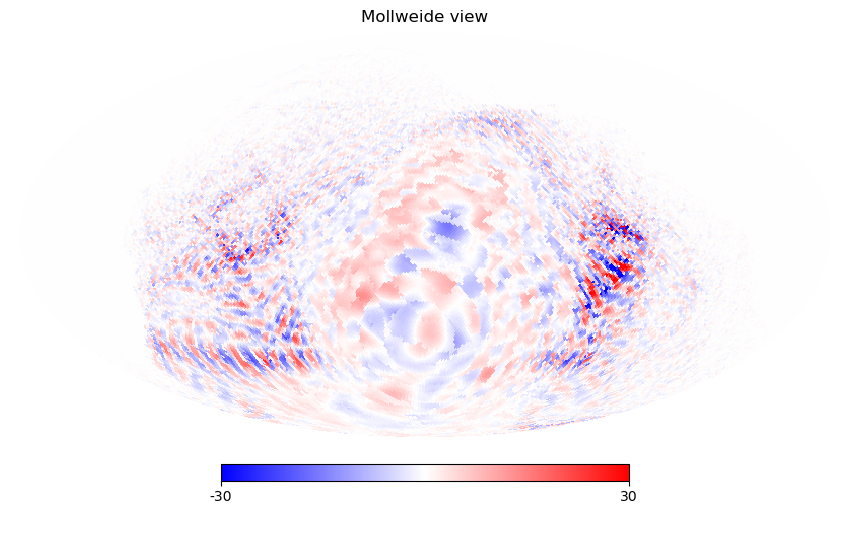

In [14]:
CH0 = freqs.size // 8
healpy.mollview(T_scat[0, :, CH0], max=30, min=-30, cmap='bwr')

In [22]:
spec0 = []
spec = []
scat = []
for hind in range(T_scat.shape[0]):
    is_gnd = (T_scat[hind, :, 0] != 0)
    scat.append(np.sum(T_scat[hind] * bm, axis=0) / np.sum(bm, axis=0))
    Tsky = gsim.sky_model.copy()
    Tsky[is_gnd, :] = TGND * (1 - gamma[None, :])**2
    spec0.append(np.sum(Tsky * bm, axis=0) / np.sum(bm, axis=0))
    Tsky[is_gnd, :] = T_scat[hind, is_gnd] + TGND * (1 - gamma[None, :])**2
    spec.append(np.sum(Tsky * bm, axis=0) / np.sum(bm, axis=0))

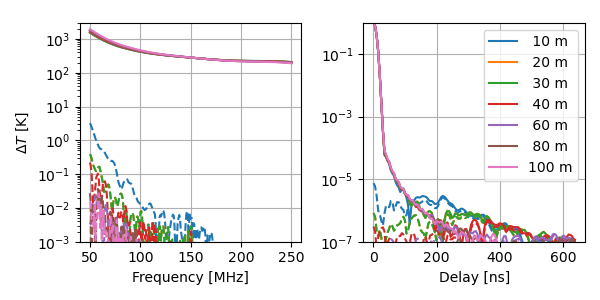

In [42]:
fig, axes = plt.subplots(ncols=2, sharex='col', figsize=(6, 3))
window = hera_filters.dspec.gen_window('bh7', freqs.size)

plot_freqs = freqs / 1e6
plot_taus = np.fft.rfftfreq(freqs.size, freqs[1]-freqs[0]) * 1e9
tilt = 1
#tilt = (freqs / 100e6)**1.5
norm = 2.0e4 * 1.8 * 0.55
for cnt, (_scat, _spec, _spec0) in enumerate(zip(scat, spec, spec0)):
    line, = axes[0].semilogy(plot_freqs, _spec * tilt)
    color = line.get_color()
    axes[1].semilogy(plot_taus, np.abs(np.fft.rfft(_spec * window * tilt))/norm, color=color, label=f'{heights[cnt]:3.0f} m')
    axes[0].plot(plot_freqs, np.abs(_spec - _spec0) * tilt, linestyle='dashed', color=color)
    axes[1].semilogy(plot_taus, np.abs(np.fft.rfft((_spec-_spec0) * window * tilt))/norm, linestyle='dashed', color=color)
axes[0].set_ylim(1e-3, 3e3)
axes[1].set_ylim(1e-7, 1e0)
axes[0].grid()
axes[1].grid()
axes[1].legend(ncol=1)
axes[0].set_xlabel('Frequency [MHz]')
axes[1].set_xlabel('Delay [ns]')
axes[0].set_ylabel('$\\Delta T$ [K]')
plt.tight_layout()